In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


# 🔃 Loading the Data

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
sub = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

In [3]:
# Remove the id column from train and test

train.drop("id",axis=1,inplace=True)
test.drop("id",axis=1,inplace=True)

# Understanding Data

In [4]:
train.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
718635,31,admin.,married,secondary,no,891,yes,no,unknown,28,may,148,1,-1,0,unknown,0
548218,42,technician,divorced,secondary,no,0,no,no,cellular,19,aug,159,2,-1,0,unknown,0
105055,39,unemployed,married,primary,no,1497,no,no,unknown,9,jun,85,2,-1,0,unknown,0
391573,32,technician,divorced,secondary,no,3100,yes,no,unknown,21,may,72,4,-1,0,unknown,0
611183,31,management,single,tertiary,no,634,yes,no,cellular,29,jan,163,1,-1,0,unknown,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   age        750000 non-null  int64 
 1   job        750000 non-null  object
 2   marital    750000 non-null  object
 3   education  750000 non-null  object
 4   default    750000 non-null  object
 5   balance    750000 non-null  int64 
 6   housing    750000 non-null  object
 7   loan       750000 non-null  object
 8   contact    750000 non-null  object
 9   day        750000 non-null  int64 
 10  month      750000 non-null  object
 11  duration   750000 non-null  int64 
 12  campaign   750000 non-null  int64 
 13  pdays      750000 non-null  int64 
 14  previous   750000 non-null  int64 
 15  poutcome   750000 non-null  object
 16  y          750000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 97.3+ MB


There are many categorical columns in the data !

In [6]:
train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


There is a very high class imbalance in target feature "y" (88% : 0, 12% 1)

In [7]:
train.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

No null or missing values in the data

# Exploratory Data Analysis

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
num_cols = list(train.select_dtypes(exclude=['object']).columns.difference(['y']))

def plot_numerical_eda(df,num_cols):
    for col in num_cols:
        skewness = df[col].skew()
        kurt = df[col].kurtosis()
        
        print(f"\nColumn: {col}")
        print(f"  Skewness: {skewness:.3f}")
        print(f"  Kurtosis: {kurt:.3f}")
        
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Histogram with KDE
        sns.histplot(df[col], kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title(f'Histogram - {col}')
        
        # Boxplot
        sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
        axes[1].set_title(f'Boxplot - {col}')
        
        # Violin plot
        sns.violinplot(x=df[col], ax=axes[2], color='lightcoral')
        axes[2].set_title(f'Violin Plot - {col}')
        
        plt.tight_layout()
        plt.show()

We need to fix the skew in the data

# Preprocessing

In [10]:
def preprocessing(df) : 

    # New feature indicating wheter the person was contacted
    # 1--> Contacted  0 --> Not contacted (-1)
    df["was_contacted"] = (df["pdays"] != -1).astype(int)

    # We need to log-transform balance feature
    # For that we need to get rid of negatve values from the column without losing their significance in the data
    df["balance_negative"] = (df["balance"] < 0).astype(int)

    df["balance"] = df["balance"].abs()  #Retain only absolute value for log tranformation
    df["balance"] = np.log1p(df["balance"]+1) # +1 to deal with 0 if any in the feature

    # Fixing skew of other features
    for col in ["campaign","pdays","previous"] :
        df[col] = np.log1p(df[col]+1)

    # Encoding binary-categorical features
    mapping = {"yes" : 1, "no" : 0}
    for col in ["default","housing","loan"] :
        df[col] = df[col].map(mapping)

    return df

In [11]:
train = preprocessing(train)
test = preprocessing(test)

In [12]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

cat_cols = list(train.select_dtypes(include=['object']).columns)
num_cols = list(train.select_dtypes(exclude=['object']).columns.difference(['y']))

le = LabelEncoder()
for col in cat_cols :
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])

scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

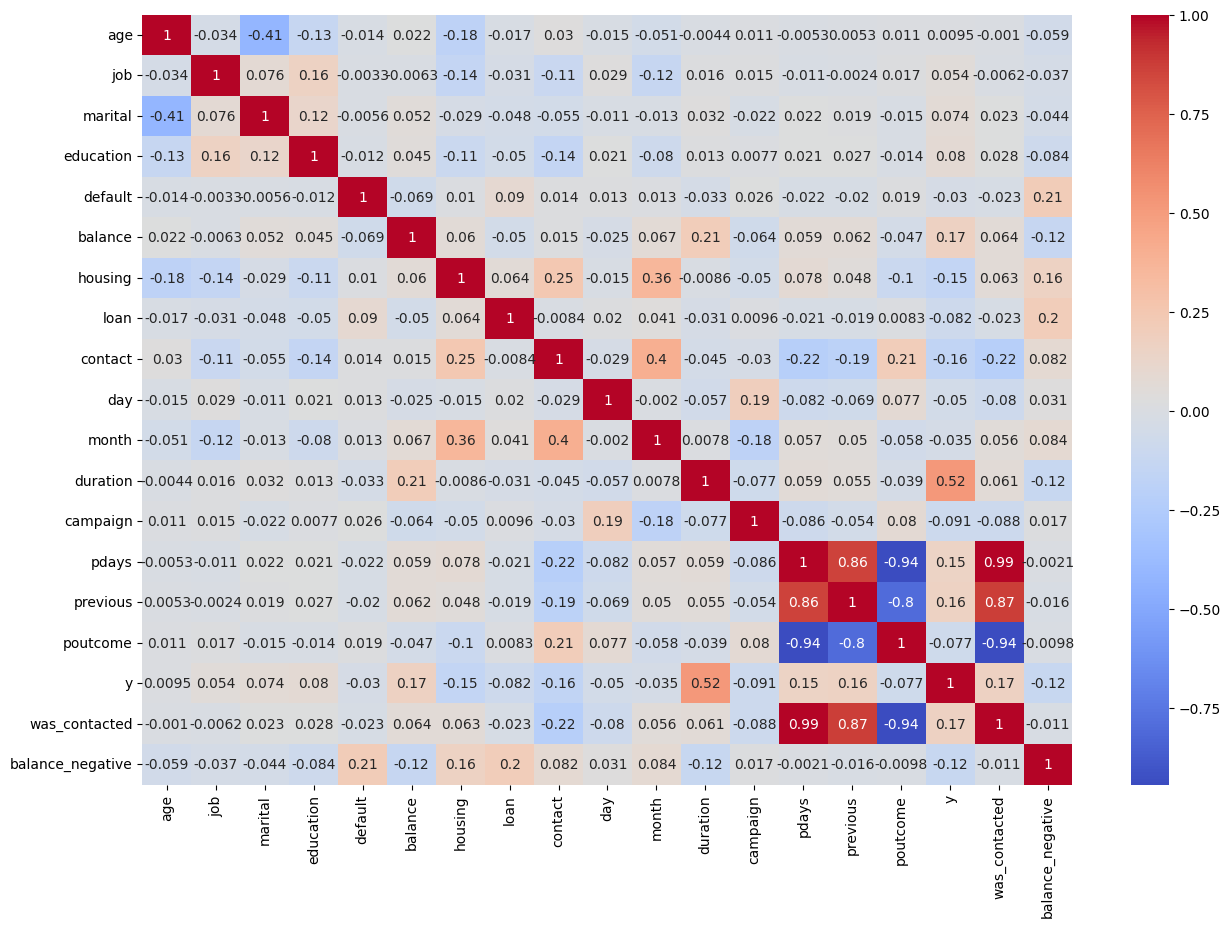

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(train.corr(),annot=True, cmap = 'coolwarm')
plt.show()

In [14]:
test.sample(5)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,was_contacted,balance_negative
84442,-0.784883,7,1,1,-0.132025,-1.984238,0.907491,-0.403422,0,0.228194,9,0.780652,-0.851039,2.876027,5.188684,0,2.944348,-0.40268
102864,0.502396,9,0,1,-0.132025,0.530207,0.907491,2.478794,0,-1.105006,8,1.980407,-0.851039,-0.337267,-0.296004,3,-0.339634,-0.40268
215210,-0.982926,0,1,1,-0.132025,0.324145,-1.101939,-0.403422,0,1.440194,4,0.846693,0.472144,-0.337267,-0.296004,3,-0.339634,-0.40268
197196,0.205331,4,1,2,-0.132025,-1.984238,-1.101939,-0.403422,0,1.561394,1,-0.657588,-0.105861,-0.337267,-0.296004,3,-0.339634,-0.40268
36777,0.502396,1,1,1,-0.132025,0.739764,-1.101939,-0.403422,0,1.076594,1,-0.690609,1.343702,-0.337267,-0.296004,3,-0.339634,-0.40268


# Model, Training Optimization, Evaluation and Prediction

In [15]:
# Best params for LightGBM using Optuna
lgb_params = {'n_estimators': 1582,
                     'max_depth': 15,
                     'learning_rate': 0.04436352313699452,
                     'num_leaves': 77,
                     'min_child_samples': 81,
                     'subsample': 0.8677563315146003,
                     'colsample_bytree': 0.5261353954090011,
                     'reg_alpha': 0.0631139742323974,
                     'reg_lambda': 6.686183660331108,
                     'verbose': -1,
                     'random_state': 42,
                     'device_type': 'gpu',
                     'gpu_platform_id': 0,
                     'gpu_device_id': 0
                  }

In [16]:
import lightgbm as lgb

from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,f1_score,recall_score,roc_auc_score
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold

In [17]:
train = train.fillna(0)
test = test.fillna(0)

In [18]:
X = train.drop("y",axis=1)
y = train["y"]

In [19]:
num_folds = 3
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
score_list = []

oof_preds = np.zeros(len(X))
test_pred = np.zeros(test.shape[0])

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):

    # Split
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[test_idx]

    # # Debug: Check dtypes
    # print(f"Fold {fold} - Data types before training:")
    # print(X_train_fold.dtypes.value_counts())
    # print(X_train_fold.dtypes)

    # If any object columns exist, raise error
    if X_train_fold.select_dtypes(include='object').shape[1] > 0:
        print("Object columns:", X_train_fold.select_dtypes(include='object').columns.tolist())
        raise ValueError(f"Object dtype found in fold {fold}")

    # Convert to numeric just in case (and fill NaNs)
    X_train_fold = X_train_fold.apply(pd.to_numeric, errors='coerce').fillna(0)
    X_val_fold   = X_val_fold.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Train model
    fold_model = lgb.LGBMClassifier(**lgb_params)
    fold_model.fit(X_train_fold, y_train_fold)

    # Predict probabilities for ROC AUC
    y_val_pred_proba = fold_model.predict_proba(X_val_fold)[:, 1]
    score = roc_auc_score(y_val_fold, y_val_pred_proba)

    # Predict labels for OOF
    y_val_pred = fold_model.predict(X_val_fold)
    oof_preds[test_idx] = y_val_pred

    print(f"Fold {fold}: Score : {score:.4f}")
    score_list.append(score)

    # Test predictions (probabilities)
    test_pred += fold_model.predict_proba(test)[:, 1]

# Average score
print(f"\nAverage Score : {np.mean(score_list):.4f}")

# Full training AUC score
training_score = roc_auc_score(y, oof_preds)
print(f"AUC Score of complete train data: {training_score:.5f}")

# Average test predictions over all folds
test_pred /= num_folds

1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold 1: Score : 0.9692
Fold 2: Score : 0.9687
Fold 3: Score : 0.9688

Average Score : 0.9689
AUC Score of complete train data: 0.82924


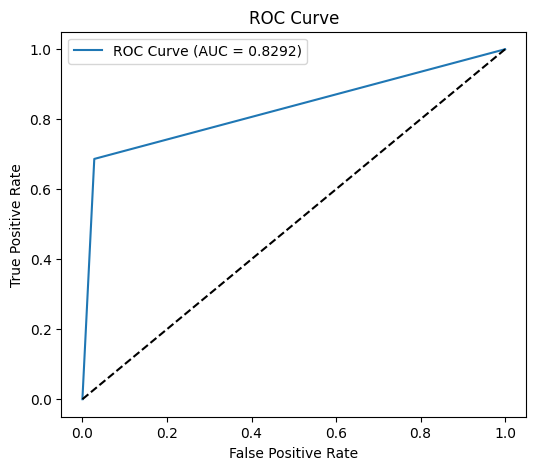

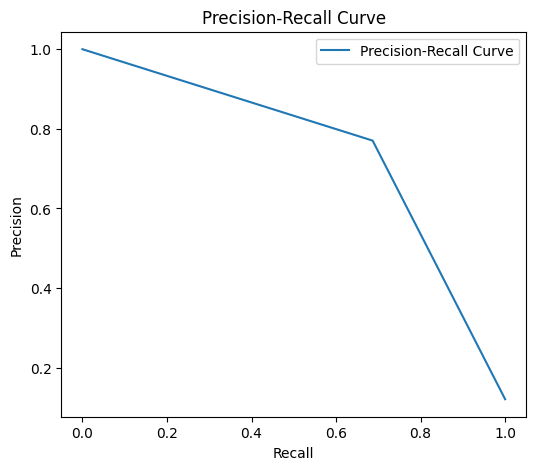

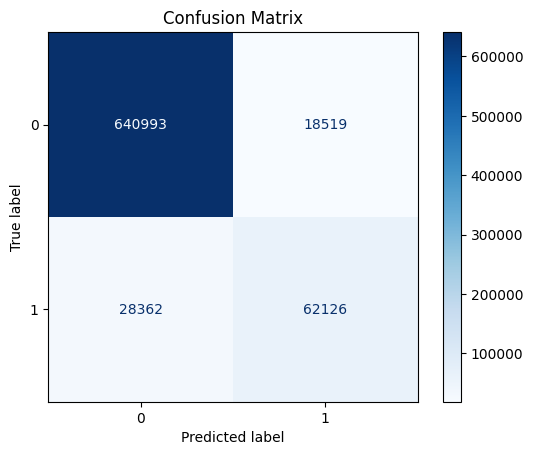

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

# ROC Curve (based on hard predictions — step-like curve)
fpr, tpr, _ = roc_curve(y, oof_preds)
auc_score = roc_auc_score(y, oof_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision-Recall Curve (also based on hard predictions)
precision, recall, _ = precision_recall_curve(y, oof_preds)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y, oof_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


# Submission

In [21]:
sub['y'] = test_pred
sub.to_csv("submission.csv",index=False)